NMF template from before:

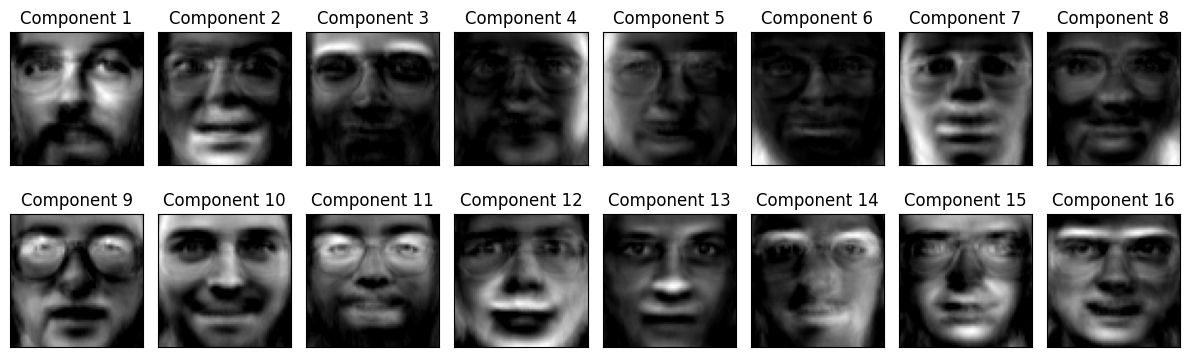

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import NMF

# 1. Load the Olivetti faces dataset
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X = faces.data
image_shape = faces.images[0].shape

# 2. Apply NMF
n_components = 16
nmf = NMF(n_components=n_components, init='random', random_state=42, max_iter=10000)
W = nmf.fit_transform(X)
H = nmf.components_

# 3. Visualize the NMF components (parts-based representation)
fig, axes = plt.subplots(2, n_components // 2, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(H[i].reshape(image_shape), cmap='gray')
    ax.set_title(f'Component {i+1}')
plt.tight_layout()
plt.show()

SAE implementation that got the parts:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_size=512, k_param=20):

        super(SparseAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.k_param = k_param

        # Pre-activation bias (decoder bias learned separately)
        self.b_pre = nn.Parameter(torch.zeros(input_size))

        # Encoder: linear projection only
        self.encoder = nn.Linear(input_size, hidden_size, bias=True)

        # Decoder: linear projection back to input space
        self.decoder = nn.Linear(hidden_size, input_size, bias=False)

        # Initialize decoder columns to unit norm
        with torch.no_grad():
            self.decoder.weight.data = F.normalize(self.decoder.weight.data, dim=0)

        # MSE normalization constant (computed during first batch)
        self.register_buffer('mse_norm', torch.tensor(1.0))
        self.mse_computed = False

    def forward(self, x):
        # Center input using pre-activation bias
        x_centered = x

        # Encoder: linear projection
        h_pre = self.encoder(x_centered)

        # Apply ReLU to ensure non-negative activations
        h = F.relu(h_pre)

        # Decoder: reconstruct input
        x_hat = self.decoder(h)

        return h, x_hat

    def compute_loss(self, x, x_hat):
        mse = F.mse_loss(x_hat, x, reduction='mean')

        return mse

    def compute_mse_normalization(self, dataloader, device, num_batches=100):
        """
        Compute MSE normalization constant from data variance.

        Args:
            dataloader: Training data loader
            device: Device to compute on
            num_batches: Number of batches to sample
        """
        all_data = []
        for i, (data, _) in enumerate(dataloader):
            if i >= num_batches:
                break
            all_data.append(data.view(-1, self.input_size))

        all_data = torch.cat(all_data, dim=0).to(device)
        self.mse_norm.data = torch.var(all_data)
        self.mse_computed = True
        print(f"MSE normalization constant: {self.mse_norm.item():.6f}")


def train_sparse_autoencoder(
    learning_rate=0.0005,
    num_epochs=100,
    batch_size=256,
    hidden_size=512,
    input_size=784,
    device='cuda'):

    # Data loading
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.LFWPeople(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Initialize model
    model = SparseAutoencoder(
        input_size=784,
        hidden_size=hidden_size,
    ).to(device)

    # Compute MSE normalization constant
    print("Computing MSE normalization constant...")
    model.compute_mse_normalization(trainloader, device)

    # Optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    print(f'\nTraining TopK Sparse Autoencoder')
    print(f'Hidden size: {hidden_size}, K: {k_param}, L0: {k_param/hidden_size:.2%}')
    print('-' * 60)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_l0 = 0.0

        for data in trainloader:
            inputs, _ = data
            inputs = inputs.view(-1, 784).to(device)

            optimizer.zero_grad()

            # Forward pass
            h, x_hat = model(inputs)
            loss = model.compute_loss(inputs, x_hat)

            # Backward pass
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Normalize decoder weights to unit norm after each update
            with torch.no_grad():
                model.decoder.weight.data = F.normalize(model.decoder.weight.data, dim=0)

            running_loss += loss.item()
            running_l0 += (h != 0).float().mean().item() * model.hidden_size

        scheduler.step()

        avg_loss = running_loss / len(trainloader)
        avg_l0 = running_l0 / len(trainloader)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, '
                  f'Avg L0: {avg_l0:.1f}, LR: {scheduler.get_last_lr()[0]:.6f}')

    print('Finished training')

    return model


def visualize_decoder_features(model, hidden_size, n_display=64):
    """Visualize decoder weight columns (what each feature contributes to reconstruction)."""
    model.eval()
    decoder_weights = model.decoder.weight.data.cpu().numpy().T  # (hidden_size, input_size)

    n_rows = int(n_display ** 0.5)
    n_cols = n_display // n_rows

    print("\nDecoder Features (what each latent adds to reconstruction):")
    plt.figure(figsize=(12, 12))
    for i in range(min(n_display, hidden_size)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(decoder_weights[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle('Decoder Weight Columns (Dictionary Atoms)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig('decoder_features.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_encoder_features(model, hidden_size, n_display=64):
    """Visualize encoder weight rows (what input patterns each latent responds to)."""
    model.eval()
    encoder_weights = model.encoder.weight.data.cpu().numpy()  # (hidden_size, input_size)

    n_rows = int(n_display ** 0.5)
    n_cols = n_display // n_rows

    print("\nEncoder Features (what patterns activate each latent):")
    plt.figure(figsize=(12, 12))
    for i in range(min(n_display, hidden_size)):
        plt.subplot(n_rows, n_cols, i + 1)
        # Normalize each encoder weight for better visualization
        weight = encoder_weights[i].reshape(28, 28)
        weight = (weight - weight.min()) / (weight.max() - weight.min() + 1e-8)
        plt.imshow(weight, cmap='viridis')
        plt.axis('off')
    plt.suptitle('Encoder Weight Rows (Feature Detectors)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig('encoder_features.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_reconstructions(model, testloader, device, n_samples=10):
    """Compare original and reconstructed images side-by-side."""
    model.eval()

    # Get a batch of test images
    data_iter = iter(testloader)
    images, labels = next(data_iter)
    images = images[:n_samples].to(device)
    labels = labels[:n_samples]

    with torch.no_grad():
        inputs = images.view(-1, 784)
        h, reconstructed = model(inputs)

        # Calculate per-sample reconstruction error
        errors = ((inputs - reconstructed) ** 2).mean(dim=1).cpu().numpy()

        # Calculate sparsity (number of active features)
        l0_counts = (h != 0).float().sum(dim=1).cpu().numpy()

    images = images.cpu().numpy()
    reconstructed = reconstructed.view(-1, 28, 28).cpu().numpy()

    print("\nReconstruction Comparison:")
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        # Original
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Original\nLabel: {labels[i].item()}', fontsize=9)
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(reconstructed[i], cmap='gray')
        plt.title(f'Recon\nL0: {int(l0_counts[i])}\nMSE: {errors[i]:.4f}', fontsize=9)
        plt.axis('off')

    plt.suptitle('Original vs Reconstructed Images', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.savefig('reconstructions.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_activation_patterns(model, testloader, device, n_samples=5):
    """Visualize which features activate for specific input images."""
    model.eval()

    # Get a few test images
    data_iter = iter(testloader)
    images, labels = next(data_iter)
    images = images[:n_samples].to(device)
    labels = labels[:n_samples]

    with torch.no_grad():
        inputs = images.view(-1, 784)
        h, reconstructed = model(inputs)

        # Get activation patterns
        h = h.cpu().numpy()

    images = images.cpu().numpy()
    reconstructed = reconstructed.view(-1, 28, 28).cpu().numpy()

    print("\nActivation Patterns for Sample Images:")
    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))

    for i in range(n_samples):
        # Original image
        axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Original (Label: {labels[i].item()})', fontsize=10)
        axes[i, 0].axis('off')

        # Reconstructed image
        axes[i, 1].imshow(reconstructed[i], cmap='gray')
        axes[i, 1].set_title('Reconstructed', fontsize=10)
        axes[i, 1].axis('off')

        # Activation pattern (which features are active)
        active_features = np.where(h[i] > 0)[0]
        activation_visual = np.zeros(model.hidden_size)
        activation_visual[active_features] = h[i][active_features]

        axes[i, 2].bar(range(len(activation_visual)), activation_visual, width=1.0)
        axes[i, 2].set_title(f'Active Features ({len(active_features)} features)', fontsize=10)
        axes[i, 2].set_xlabel('Feature Index')
        axes[i, 2].set_ylabel('Activation Strength')
        axes[i, 2].set_xlim([0, model.hidden_size])

        # Top 3 active features visualization
        top_k_idx = np.argsort(h[i])[-3:][::-1]
        decoder_weights = model.decoder.weight.data.cpu().numpy().T

        combined_feature = np.zeros((28, 28))
        for idx in top_k_idx:
            if h[i][idx] > 0:
                combined_feature += h[i][idx] * decoder_weights[idx].reshape(28, 28)

        axes[i, 3].imshow(combined_feature, cmap='gray')
        axes[i, 3].set_title(f'Top 3 Features Combined\n({top_k_idx[0]}, {top_k_idx[1]}, {top_k_idx[2]})', fontsize=9)
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig('activation_patterns.png', dpi=150, bbox_inches='tight')
    plt.show()


def compare_encoder_decoder_relationship(model, n_display=8):
    """Compare encoder and decoder weights for the same features."""
    model.eval()

    encoder_weights = model.encoder.weight.data.cpu().numpy()  # (hidden_size, input_size)
    decoder_weights = model.decoder.weight.data.cpu().numpy().T  # (hidden_size, input_size)

    # Select random features to display
    indices = np.random.choice(model.hidden_size, n_display, replace=False)

    print("\nEncoder-Decoder Weight Comparison:")
    plt.figure(figsize=(16, 4))

    for i, idx in enumerate(indices):
        # Encoder weight
        plt.subplot(2, n_display, i + 1)
        enc_weight = encoder_weights[idx].reshape(28, 28)
        enc_weight = (enc_weight - enc_weight.min()) / (enc_weight.max() - enc_weight.min() + 1e-8)
        plt.imshow(enc_weight, cmap='viridis')
        plt.title(f'Enc {idx}', fontsize=9)
        plt.axis('off')

        # Decoder weight
        plt.subplot(2, n_display, n_display + i + 1)
        dec_weight = decoder_weights[idx].reshape(28, 28)
        plt.imshow(dec_weight, cmap='gray')
        plt.title(f'Dec {idx}', fontsize=9)
        plt.axis('off')

    plt.suptitle('Encoder (top) vs Decoder (bottom) Weights for Same Features', fontsize=12)
    plt.tight_layout()
    plt.savefig('encoder_decoder_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()




SyntaxError: invalid syntax (3339214167.py, line 83)

So lets first load the face dataset for SAE:

In [3]:
# Shared preprocessing
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# Fetch data
lfw = fetch_lfw_people(color=False, resize=1.0, min_faces_per_person=0)
X = lfw.images    # shape: (n_samples, height, width)
X_flat = X.reshape(X.shape[0], -1)  # shape: (n_samples, n_features)
X_flat = X_flat / X_flat.max()      # scale to [0, 1], ensure non-negative

X_train, X_test = train_test_split(X_flat, test_size=0.2, random_state=42)

# Convert to tensors for PyTorch training
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)



In [4]:
model = train_sparse_autoencoder(
    train_loader,
    input_size=11750,
    hidden_size=640)

TypeError: train_sparse_autoencoder() got an unexpected keyword argument 'input_size'

In [ ]:
# python
image_shape = lfw.images[0].shape  # (125, 94) when resize=1.0

import matplotlib.pyplot as plt
import numpy as np

def visualize_encoder_features(model, n_display=64, image_shape=image_shape):
    model.eval()
    W = model.encoder.weight.data.cpu().numpy()  # (hidden_size, input_size)

    n_display = min(n_display, W.shape[0])
    n_rows = int(np.floor(np.sqrt(n_display)))
    n_cols = int(np.ceil(n_display / n_rows))

    plt.figure(figsize=(12, 12))
    for i in range(n_display):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        weight = W[i].reshape(image_shape)
        weight = (weight - weight.min()) / (weight.max() - weight.min() + 1e-8)
        ax.imshow(weight, cmap='gray')
        ax.axis('off')
    plt.suptitle('Encoder Weight Rows (Feature Detectors)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()

visualize_encoder_features(model, 64)

Using device: cuda

Training NNSAE (Nonnegative Sparse Autoencoder)
Hidden size: 196, Sparsity target: 0.05, Beta: 3.0
Key features: Tied weights, Linear output, Hard nonnegativity constraint
Data normalized to [0,1]
------------------------------------------------------------
Epoch [10/200], Loss: 0.0827, MSE: 0.0810, KL: 0.0006, Sparsity: 0.001, AvgAct: 0.0499, LR: 0.010000
Epoch [20/200], Loss: 0.0697, MSE: 0.0684, KL: 0.0004, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.010000
Epoch [30/200], Loss: 0.0689, MSE: 0.0676, KL: 0.0004, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.010000
Epoch [40/200], Loss: 0.0687, MSE: 0.0675, KL: 0.0004, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.010000
Epoch [50/200], Loss: 0.0686, MSE: 0.0675, KL: 0.0004, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.005000
Epoch [60/200], Loss: 0.0685, MSE: 0.0675, KL: 0.0003, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.005000
Epoch [70/200], Loss: 0.0685, MSE: 0.0675, KL: 0.0003, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.005000
Epoch [80/200],

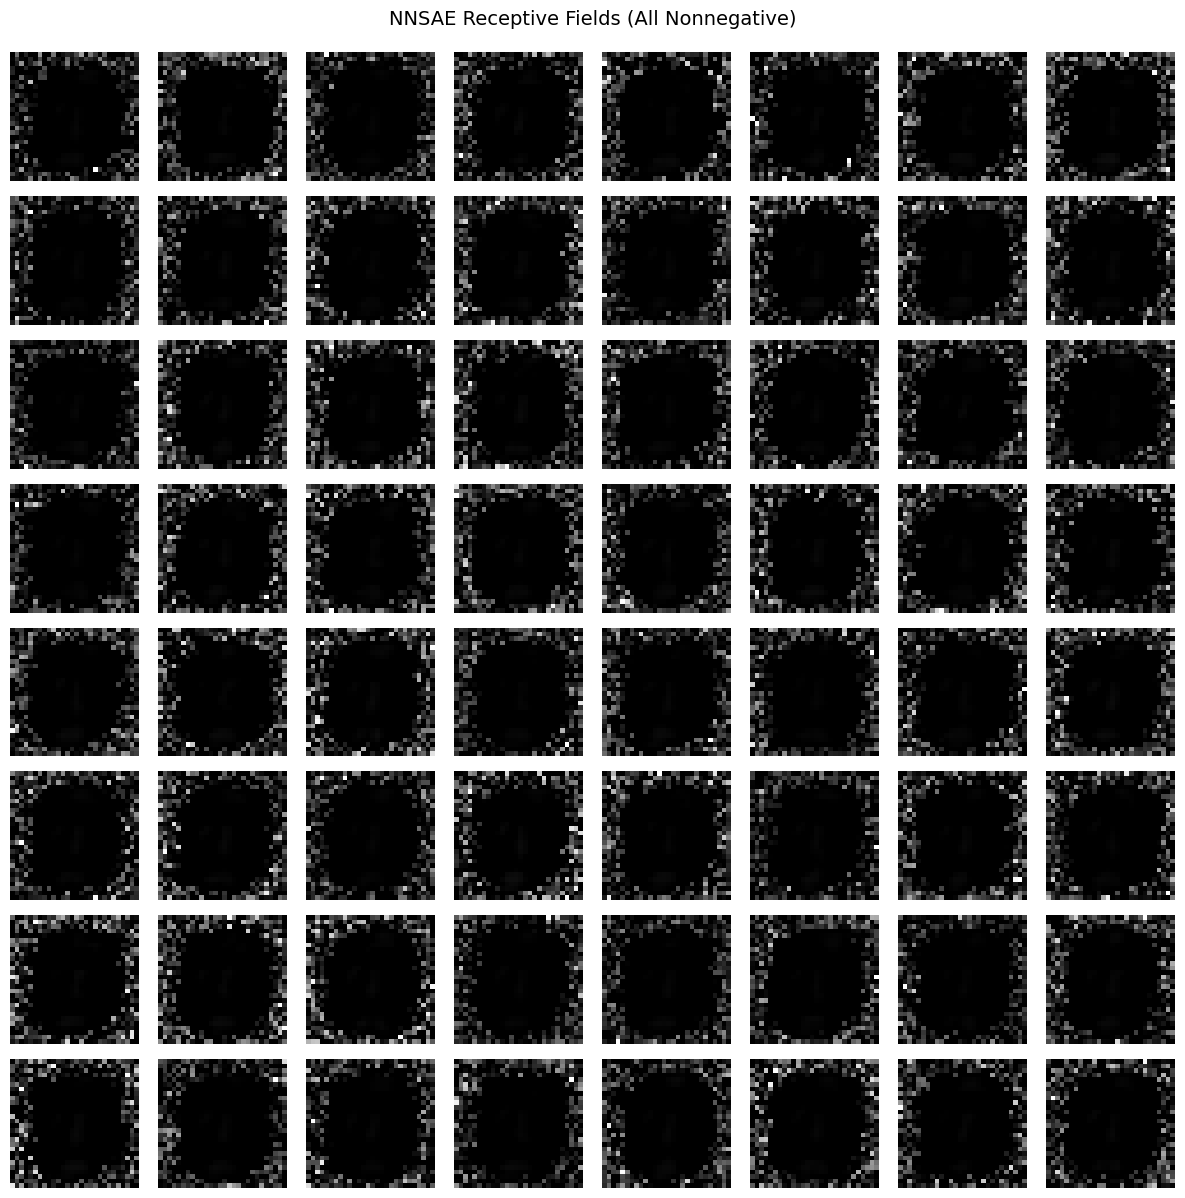


NNSAE Reconstruction Comparison:


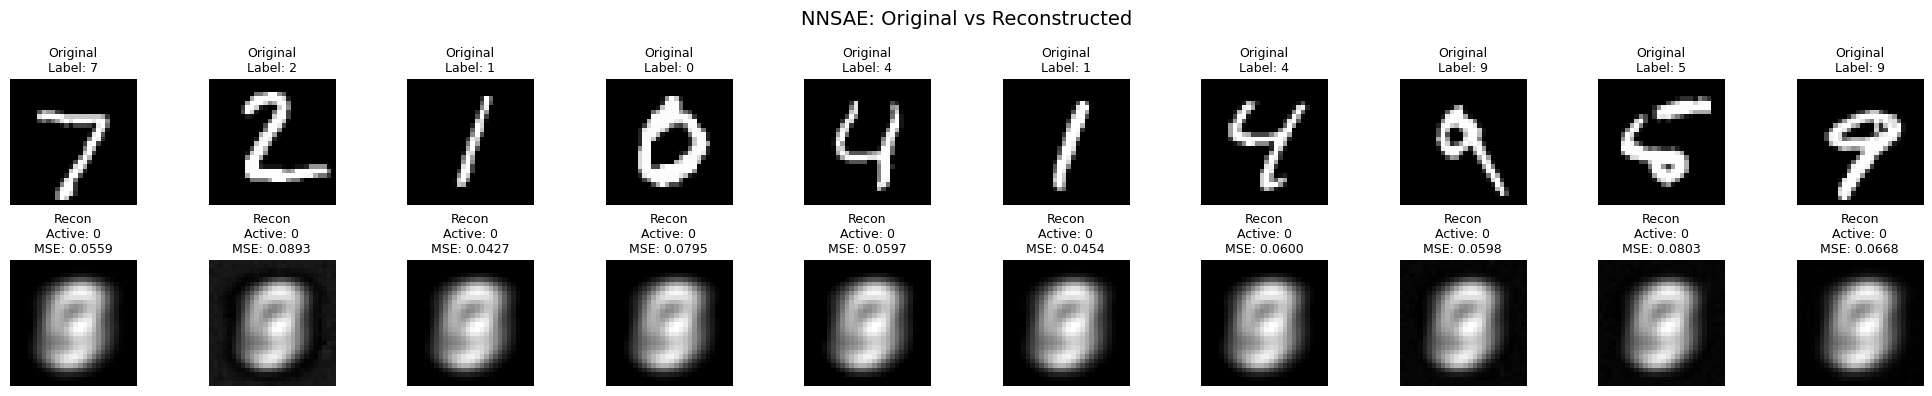

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

class NNSAE(nn.Module):
    """
    Nonnegative Sparse Autoencoder (NNSAE) - Lemme et al. 2012
    """
    def __init__(self, input_size=784, hidden_size=196, sparsity_target=0.05):
        super(NNSAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sparsity_target = sparsity_target

        # Encoder weights and bias
        self.W1 = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.b1 = nn.Parameter(torch.zeros(hidden_size))

        # Decoder bias (weights are tied)
        self.b2 = nn.Parameter(torch.zeros(input_size))

        # Initialize weights to be nonnegative
        with torch.no_grad():
            self.W1.data = torch.abs(self.W1.data)

    def forward(self, x):
        # Encoder: h = sigmoid(W1 * x + b1)
        h_pre = torch.matmul(x, self.W1.t()) + self.b1
        h = torch.sigmoid(h_pre)

        # Decoder: x_hat = W1^T * h + b2 (LINEAR output)
        x_hat = torch.matmul(h, self.W1) + self.b2

        return h, x_hat

    def compute_loss(self, x, h, x_hat, beta=3.0):
        # Reconstruction error (MSE)
        mse = F.mse_loss(x_hat, x, reduction='mean')

        # Sparsity constraint (KL divergence)
        rho_hat = torch.mean(h, dim=0)  # Average activation per hidden unit
        rho = torch.full_like(rho_hat, self.sparsity_target)

        # KL divergence with numerical stability
        epsilon = 1e-10
        rho_hat = torch.clamp(rho_hat, epsilon, 1 - epsilon)

        kl_div = torch.sum(
            rho * torch.log(rho / rho_hat) +
            (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
        )

        # Total loss
        loss = mse + beta * kl_div

        return loss, mse, kl_div

    def enforce_nonnegativity(self):
        """Hard constraint: clip all negative weights to zero"""
        with torch.no_grad():
            self.W1.data.clamp_(min=0.0)


def train_nnsae(
    learning_rate=0.01,
    num_epochs=200,
    batch_size=128,
    hidden_size=196,
    sparsity_target=0.05,
    beta=3.0,
    device='cuda'):

    # CRITICAL: Normalize data to [0,1]
    transform = transforms.Compose([
        transforms.ToTensor(),  # Already normalizes to [0,1]
    ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize model
    model = NNSAE(
        input_size=784,
        hidden_size=hidden_size,
        sparsity_target=sparsity_target
    ).to(device)

    # Use SGD (closer to paper's L-BFGS in spirit)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Gentler learning rate decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    print(f'\nTraining NNSAE (Nonnegative Sparse Autoencoder)')
    print(f'Hidden size: {hidden_size}, Sparsity target: {sparsity_target}, Beta: {beta}')
    print(f'Key features: Tied weights, Linear output, Hard nonnegativity constraint')
    print(f'Data normalized to [0,1]')
    print('-' * 60)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_mse = 0.0
        running_kl = 0.0
        running_sparsity = 0.0
        running_avg_activation = 0.0

        for data in trainloader:
            inputs, _ = data
            inputs = inputs.view(-1, 784).to(device)

            optimizer.zero_grad()

            # Forward pass
            h, x_hat = model(inputs)
            loss, mse, kl_div = model.compute_loss(inputs, h, x_hat, beta=beta)

            # Backward pass
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            # CRITICAL: Enforce hard nonnegativity constraint
            model.enforce_nonnegativity()

            running_loss += loss.item()
            running_mse += mse.item()
            running_kl += kl_div.item()
            # Sparsity: fraction of units active (> threshold)
            running_sparsity += torch.mean((h > 0.1).float()).item()
            running_avg_activation += torch.mean(h).item()

        scheduler.step()

        avg_loss = running_loss / len(trainloader)
        avg_mse = running_mse / len(trainloader)
        avg_kl = running_kl / len(trainloader)
        avg_sparsity = running_sparsity / len(trainloader)
        avg_activation = running_avg_activation / len(trainloader)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, '
                  f'MSE: {avg_mse:.4f}, KL: {avg_kl:.4f}, '
                  f'Sparsity: {avg_sparsity:.3f}, AvgAct: {avg_activation:.4f}, '
                  f'LR: {scheduler.get_last_lr()[0]:.6f}')

    print('Finished training NNSAE')

    # Report weight statistics
    total_weights = model.W1.numel()
    nonneg_weights = (model.W1 >= 0).sum().item()
    nonzero_weights = (model.W1 > 1e-6).sum().item()
    print(f'Nonnegative weights: {nonneg_weights}/{total_weights} ({100*nonneg_weights/total_weights:.2f}%)')
    print(f'Non-zero weights (>1e-6): {nonzero_weights}/{total_weights} ({100*nonzero_weights/total_weights:.2f}%)')
    print(f'Weight statistics: Min={model.W1.min():.6f}, Max={model.W1.max():.6f}, Mean={model.W1.mean():.6f}')

    return model, testloader


# Keep your visualization functions unchanged
def visualize_nnsae_features(model, n_display=64):
    """Visualize encoder weights"""
    model.eval()
    encoder_weights = model.W1.data.cpu().numpy()

    n_rows = int(n_display ** 0.5)
    n_cols = n_display // n_rows

    print("\nNNSAE Encoder Features (Receptive Fields):")
    plt.figure(figsize=(12, 12))
    for i in range(min(n_display, model.hidden_size)):
        plt.subplot(n_rows, n_cols, i + 1)
        weight = encoder_weights[i].reshape(28, 28)
        plt.imshow(weight, cmap='gray', vmin=0, vmax=weight.max())
        plt.axis('off')
    plt.suptitle('NNSAE Receptive Fields (All Nonnegative)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig('nnsae_features_fixed.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_reconstructions(model, testloader, device, n_samples=10):
    """Compare original and reconstructed images"""
    model.eval()

    data_iter = iter(testloader)
    images, labels = next(data_iter)
    images = images[:n_samples].to(device)
    labels = labels[:n_samples]

    with torch.no_grad():
        inputs = images.view(-1, 784)
        h, reconstructed = model(inputs)

        # Clip reconstruction to [0,1] for display
        reconstructed = torch.clamp(reconstructed, 0, 1)

        errors = ((inputs - reconstructed) ** 2).mean(dim=1).cpu().numpy()
        sparsity = (h > 0.1).float().sum(dim=1).cpu().numpy()

    images = images.cpu().numpy()
    reconstructed = reconstructed.view(-1, 28, 28).cpu().numpy()

    print("\nNNSAE Reconstruction Comparison:")
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Original\nLabel: {labels[i].item()}', fontsize=9)
        plt.axis('off')

        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(reconstructed[i], cmap='gray')
        plt.title(f'Recon\nActive: {int(sparsity[i])}\nMSE: {errors[i]:.4f}', fontsize=9)
        plt.axis('off')

    plt.suptitle('NNSAE: Original vs Reconstructed', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.savefig('nnsae_reconstructions_fixed.png', dpi=150, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Train NNSAE with proper settings
    model, testloader = train_nnsae(
        learning_rate=0.01,        # Lower LR
        num_epochs=200,            # More epochs
        batch_size=128,            # Smaller batch
        hidden_size=196,
        sparsity_target=0.05,
        beta=3.0,
        device=device
    )

    # Visualizations
    visualize_nnsae_features(model, n_display=64)
    visualize_reconstructions(model, testloader, device, n_samples=10)


Using device: cuda

Training NNSAE (Nonnegative Sparse Autoencoder)
Hidden size: 196, Sparsity target: 0.05, Beta: 3.0
Key features: Tied weights, Linear output, Hard nonnegativity constraint
Data normalized to [0,1]
------------------------------------------------------------
Epoch [10/200], Loss: 0.0827, MSE: 0.0810, KL: 0.0006, Sparsity: 0.001, AvgAct: 0.0499, LR: 0.010000
Epoch [20/200], Loss: 0.0698, MSE: 0.0684, KL: 0.0005, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.010000
Epoch [30/200], Loss: 0.0690, MSE: 0.0676, KL: 0.0004, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.010000
Epoch [40/200], Loss: 0.0687, MSE: 0.0676, KL: 0.0004, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.010000
Epoch [50/200], Loss: 0.0687, MSE: 0.0675, KL: 0.0004, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.005000
Epoch [60/200], Loss: 0.0684, MSE: 0.0675, KL: 0.0003, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.005000
Epoch [70/200], Loss: 0.0685, MSE: 0.0675, KL: 0.0003, Sparsity: 0.000, AvgAct: 0.0500, LR: 0.005000
Epoch [80/200],

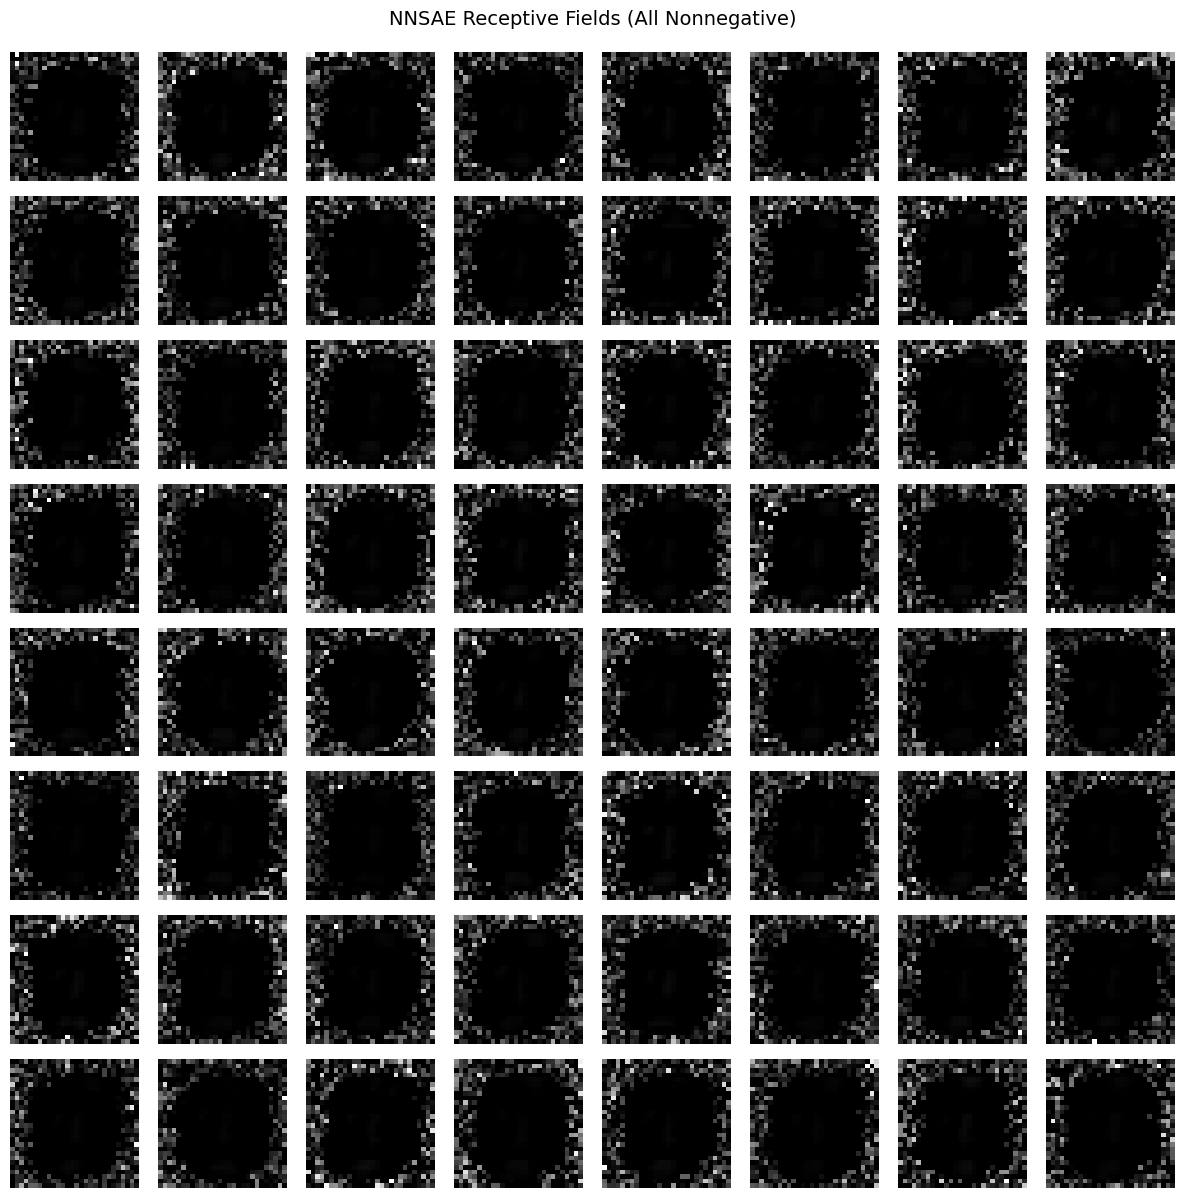


NNSAE Reconstruction Comparison:


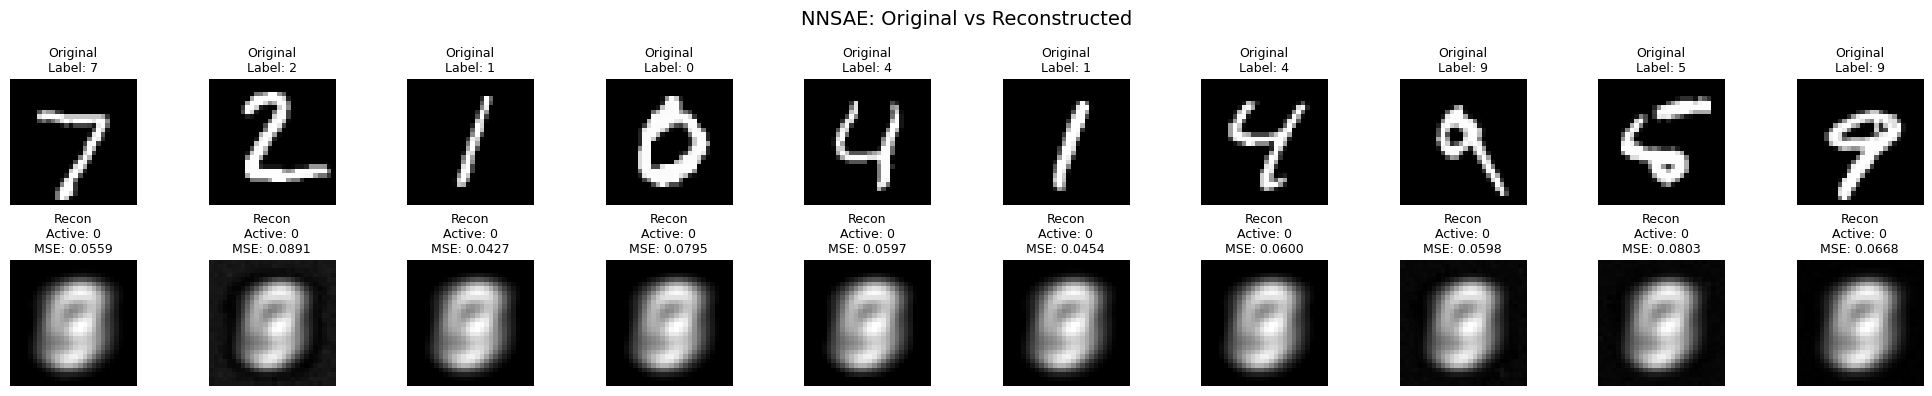

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

class NNSAE(nn.Module):
    """
    Nonnegative Sparse Autoencoder (NNSAE) - Lemme et al. 2012
    """
    def __init__(self, input_size=784, hidden_size=196, sparsity_target=0.05):
        super(NNSAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sparsity_target = sparsity_target

        # Encoder weights and bias
        self.W1 = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.b1 = nn.Parameter(torch.zeros(hidden_size))

        # Decoder bias (weights are tied)
        self.b2 = nn.Parameter(torch.zeros(input_size))

        # Initialize weights to be nonnegative
        with torch.no_grad():
            self.W1.data = torch.abs(self.W1.data)

    def forward(self, x):
        # Encoder: h = sigmoid(W1 * x + b1)
        h_pre = torch.matmul(x, self.W1.t()) + self.b1
        h = torch.sigmoid(h_pre)

        # Decoder: x_hat = W1^T * h + b2 (LINEAR output)
        x_hat = torch.matmul(h, self.W1) + self.b2

        return h, x_hat

    def compute_loss(self, x, h, x_hat, beta=3.0):
        # Reconstruction error (MSE)
        mse = F.mse_loss(x_hat, x, reduction='mean')

        # Sparsity constraint (KL divergence)
        rho_hat = torch.mean(h, dim=0)  # Average activation per hidden unit
        rho = torch.full_like(rho_hat, self.sparsity_target)

        # KL divergence with numerical stability
        epsilon = 1e-10
        rho_hat = torch.clamp(rho_hat, epsilon, 1 - epsilon)

        kl_div = torch.sum(
            rho * torch.log(rho / rho_hat) +
            (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
        )

        # Total loss
        loss = mse + beta * kl_div

        return loss, mse, kl_div

    def enforce_nonnegativity(self):
        """Hard constraint: clip all negative weights to zero"""
        with torch.no_grad():
            self.W1.data.clamp_(min=0.0)


def train_nnsae(
    learning_rate=0.01,
    num_epochs=200,
    batch_size=128,
    hidden_size=196,
    sparsity_target=0.05,
    beta=3.0,
    device='cuda'):

    # CRITICAL: Normalize data to [0,1]
    transform = transforms.Compose([
        transforms.ToTensor(),  # Already normalizes to [0,1]
    ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize model
    model = NNSAE(
        input_size=784,
        hidden_size=hidden_size,
        sparsity_target=sparsity_target
    ).to(device)

    # Use SGD (closer to paper's L-BFGS in spirit)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Gentler learning rate decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    print(f'\nTraining NNSAE (Nonnegative Sparse Autoencoder)')
    print(f'Hidden size: {hidden_size}, Sparsity target: {sparsity_target}, Beta: {beta}')
    print(f'Key features: Tied weights, Linear output, Hard nonnegativity constraint')
    print(f'Data normalized to [0,1]')
    print('-' * 60)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_mse = 0.0
        running_kl = 0.0
        running_sparsity = 0.0
        running_avg_activation = 0.0

        for data in trainloader:
            inputs, _ = data
            inputs = inputs.view(-1, 784).to(device)

            optimizer.zero_grad()

            # Forward pass
            h, x_hat = model(inputs)
            loss, mse, kl_div = model.compute_loss(inputs, h, x_hat, beta=beta)

            # Backward pass
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            # CRITICAL: Enforce hard nonnegativity constraint
            model.enforce_nonnegativity()

            running_loss += loss.item()
            running_mse += mse.item()
            running_kl += kl_div.item()
            # Sparsity: fraction of units active (> threshold)
            running_sparsity += torch.mean((h > 0.1).float()).item()
            running_avg_activation += torch.mean(h).item()

        scheduler.step()

        avg_loss = running_loss / len(trainloader)
        avg_mse = running_mse / len(trainloader)
        avg_kl = running_kl / len(trainloader)
        avg_sparsity = running_sparsity / len(trainloader)
        avg_activation = running_avg_activation / len(trainloader)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, '
                  f'MSE: {avg_mse:.4f}, KL: {avg_kl:.4f}, '
                  f'Sparsity: {avg_sparsity:.3f}, AvgAct: {avg_activation:.4f}, '
                  f'LR: {scheduler.get_last_lr()[0]:.6f}')

    print('Finished training NNSAE')

    # Report weight statistics
    total_weights = model.W1.numel()
    nonneg_weights = (model.W1 >= 0).sum().item()
    nonzero_weights = (model.W1 > 1e-6).sum().item()
    print(f'Nonnegative weights: {nonneg_weights}/{total_weights} ({100*nonneg_weights/total_weights:.2f}%)')
    print(f'Non-zero weights (>1e-6): {nonzero_weights}/{total_weights} ({100*nonzero_weights/total_weights:.2f}%)')
    print(f'Weight statistics: Min={model.W1.min():.6f}, Max={model.W1.max():.6f}, Mean={model.W1.mean():.6f}')

    return model, testloader


# Keep your visualization functions unchanged
def visualize_nnsae_features(model, n_display=64):
    """Visualize encoder weights"""
    model.eval()
    encoder_weights = model.W1.data.cpu().numpy()

    n_rows = int(n_display ** 0.5)
    n_cols = n_display // n_rows

    print("\nNNSAE Encoder Features (Receptive Fields):")
    plt.figure(figsize=(12, 12))
    for i in range(min(n_display, model.hidden_size)):
        plt.subplot(n_rows, n_cols, i + 1)
        weight = encoder_weights[i].reshape(28, 28)
        plt.imshow(weight, cmap='gray', vmin=0, vmax=weight.max())
        plt.axis('off')
    plt.suptitle('NNSAE Receptive Fields (All Nonnegative)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig('nnsae_features_fixed.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_reconstructions(model, testloader, device, n_samples=10):
    """Compare original and reconstructed images"""
    model.eval()

    data_iter = iter(testloader)
    images, labels = next(data_iter)
    images = images[:n_samples].to(device)
    labels = labels[:n_samples]

    with torch.no_grad():
        inputs = images.view(-1, 784)
        h, reconstructed = model(inputs)

        # Clip reconstruction to [0,1] for display
        reconstructed = torch.clamp(reconstructed, 0, 1)

        errors = ((inputs - reconstructed) ** 2).mean(dim=1).cpu().numpy()
        sparsity = (h > 0.1).float().sum(dim=1).cpu().numpy()

    images = images.cpu().numpy()
    reconstructed = reconstructed.view(-1, 28, 28).cpu().numpy()

    print("\nNNSAE Reconstruction Comparison:")
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Original\nLabel: {labels[i].item()}', fontsize=9)
        plt.axis('off')

        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(reconstructed[i], cmap='gray')
        plt.title(f'Recon\nActive: {int(sparsity[i])}\nMSE: {errors[i]:.4f}', fontsize=9)
        plt.axis('off')

    plt.suptitle('NNSAE: Original vs Reconstructed', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.savefig('nnsae_reconstructions_fixed.png', dpi=150, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Train NNSAE with proper settings
    model, testloader = train_nnsae(
        learning_rate=0.01,        # Lower LR
        num_epochs=200,            # More epochs
        batch_size=128,            # Smaller batch
        hidden_size=196,
        sparsity_target=0.05,
        beta=3.0,
        device=device
    )

    # Visualizations
    visualize_nnsae_features(model, n_display=64)
    visualize_reconstructions(model, testloader, device, n_samples=10)
